<a href="https://colab.research.google.com/github/hishamalboo/Analyze-A-B-Test-Results-e-commerce-website/blob/main/Analyze_ab_test_results_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyze A/B Test Results e-commerce website


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I am trying to interpret the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
from google.colab import drive
import pandas  as pd
drive.mount('/content/drive')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import seaborn as sb
from sklearn import linear_model
from datetime import datetime
from timeit import default_timer as timer
from IPython.display import display
pd.set_option("display.max_columns", 10000)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 1)
import random
%load_ext google.colab.data_table
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
#Reading dataset from my local disk:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/a b test/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
(df.iloc[:,:]['converted']==1).value_counts().loc[True]/df.shape[0]


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
false_line_up = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index
df2 = df.drop(false_line_up,axis=0)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# number of dublicated rows:
df2.duplicated(subset = ["user_id"]).value_counts().loc[True]

1

In [14]:
df2[df2.duplicated(subset = ["user_id"])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.duplicated(subset = ["user_id"],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(df2[df2.duplicated(subset = ["user_id"])].index,inplace=True)
df2[df2.duplicated(subset = ["user_id"], keep = False)] 

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
(df2.query('converted==1')).shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
(df2.query('group=="control"')['converted']==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
(df2.query('group=="treatment"')['converted']==1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2.query('landing_page=="new_page"')).shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

##### From question No. 4, we conclude as follows:
- The Probability of converting regardless of page is: 11.96%.
- Given an individual received the control page, the probability of converting is: 12.04% 
- Given that an individual received the treatment page, the probability of converting is: 11.88%.
- The probability of receiving the new page is: 50.01%.

That's mean the users received the new or the old page in a ration very close to 50/50. The probabilities of converting in the control group and the treatment group are very close to each other, with a difference of 0.16%. This small difference could also appear by chance, therefore we don't have sufficient evidence to conclude that the new treatment page leads to more conversions than the old page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


    
**$$H_{0}: p_{new} - p_{old} <= 0$$**

**$$H_{1}: p_{new} - p_{old} > 0$$**



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = (df2.query('converted==1')).shape[0]/df2.shape[0]
print(p_new)

0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = (df2.query('converted==1')).shape[0]/df2.shape[0]
print(p_old)

0.11959708724499628


c. What is $n_{new}$?

In [23]:
n_new = df2.query("group == 'treatment'").shape[0]
print(n_new)

145310


d. What is $n_{old}$?

In [24]:
n_old = df2.query("group == 'control'").shape[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
new_page_converted.mean()

0.12069368935379533

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = [p_old, (1-p_old)])
old_page_converted.mean()

0.12188691713589493

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0011932277820995985

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
# For 10,000 iterations, we bootstrap sample  of  the coversion rates of the old page and the conversion rates of the new page
# and calculate the difference converion rate:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, replace = True, p = (p_new, 1-p_new))
    old_page_converted = np.random.choice([1,0], size = n_old, replace = True, p = (p_old, 1-p_old))
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)
p_diffs = np.array(p_diffs)    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

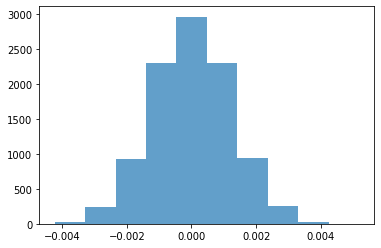

In [29]:
plt.hist(p_diffs,alpha=0.7);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# Building actual differenece :
p_actual_old = (df2.query('group=="control"')['converted']==1).mean()
p_actual_new = (df2.query('group=="treatment"')['converted']==1).mean()
actual_diff = p_actual_new - p_actual_old

#Buliding null values:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Calculate proportion of the p_diffs are greater than the actual difference observed in dataset:
p_value=(null_vals > actual_diff).mean()
print('\033[1m' +'Proportion of the p_diffs are greater than the actual difference observed in dataset : ', p_value)

Proportion of the p_diffs are greater than the actual difference observed in dataset :  0.9029


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

***We assumed that the null hypothesis is true. With that, we assume that p_old = p_new, so both pages have the same converting rates over the whole sample. Therefore we also assume, that the individual converting probability of each page is equal to the one of the whole sample. Based on that, we bootstrapped a sampling distribution for both pages and calculated the differences in the converting probability per page with n equal to the original number of people who received each page and a converting probability of 0.119597.***

***With the resulting standard deviation of the differences (which is coming from the simulated population), we then calcualted values coming from a normal distribution around 0. As last step we calculated the proportion of values which are bigger than the actually observed difference. The calculated p-value now tells us the probability of receiving this observed statistic if the null hypothesis is true.***

### With a Type-I-Error-Rate of 0.05, we can say that the proportion of difference coversion rates of the old page and the conversion rates of the new page is greater than  0.05 "0.9>0.05", therefore we don't have enough evidence to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = (df2.query('group=="control"')['converted']==1).sum()
convert_new =(df2.query('group=="treatment"')['converted']==1).sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
# this link "http://knowledgetack.com/python/statsmodels/proportions_ztest/" is not work it was mention in 'm' statement,
# so I use the same  consistency in this link: https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/:
from scipy.stats import norm

#calculate z-test and p-value:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")

#calculate the critical z_term:
z_critical=norm.ppf(1-(0.05))

print('\033[1m' +"P-Value: ", p_value,"\nZ-Score: ",z_score, "\nCritical Z-Score: ", z_critical)

P-Value:  0.9050583127590245 
Z-Score:  1.3109241984234394 
Critical Z-Score:  1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

***The p-value here agrees with our seekings in j statement . Also the calculated Z-Score is smaller than the Critical Z - Score, so we also fail to reject the null hypothesis based on the Z-test.*** 

***In conclusion, we accept the null hypothesis that the coversion rates of the old page are equal or better than the conversion rates of the new page.***

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

***Since the dataset contains binary, a logistic regression should be performed.***

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# Let make copy of dataset called 'df_logistic': 
df_logistic = df2.copy()

#add intercept
df_logistic["intercept"] = 1

#Let create the dummies 
df_logistic = df_logistic.join(pd.get_dummies(df_logistic['group']))
df_logistic.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [34]:
#Let  rename the column 'treatment' to 'ab_page'
# the column 'ab_page' is consider that if an individual receives the treatment it takes value '1' , otherwise '0':
df_logistic.rename(columns = {"treatment": "ab_page"}, inplace=True)
df_logistic.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
# Let load the model and fit it:
y = df_logistic["converted"]
x = df_logistic[["intercept", "ab_page"]]

log_mod = sm.Logit(y,x)

result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:09:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

***Based on that "P-value" we can say, that the conversion is not significant dependent on the page.***

***The "P-value" associated with ab_page is 0.19. This is because the approach of calculating the "P-value" is different for each case. In 'Part II' we calculate the probability receiving a observed statistic if the null hypothesis is true. Therefore this is a one-sided test. However,in 'Part III' the ab_page P-value is the result of a two sided test, because the null hypothesis for this case is, that there is no significant relationship between the conversion rate and ab_page.***



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***Adding other factors in the model could lead to more precise(low variance) results and a higher accuracy(low bias). The disadvantages are the increasing complexity of interpretation or the possible lead to build model more deception.***

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Let reading dataset "countries" in variable "countries_df" from my local disk:
countries_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/a b test/countries.csv')

# Let making join countries_df dataset with df_logistic dataset I have created it in  Part III and save this join in df_new:
df_new = countries_df.set_index('user_id').join(df_logistic.set_index('user_id'), how='inner')

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [38]:
# Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [39]:
# Let load the model and fit it:
y = df_new["converted"]
x = df_new[["intercept", "ab_page", "CA", "UK"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:               2.323e-05
Time:                        21:10:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

#### Let create reciprocal exponential for all coefficients were mention above:

In [40]:
rec_exp_cof_ab_page=1/np.exp(-0.0149)
rec_exp_cof_CA=1/np.exp(-0.0408)
rec_exp_cof_UK=1/np.exp(0.0099)

print('\033[1m' +" ab_page's coefficient is : -0.0149, reciprocal exponential is",rec_exp_cof_ab_page,
      "\n"*2,"CA's coefficient is : -0.0408, reciprocal exponential is",rec_exp_cof_CA,
       "\n"*2,"UK's coefficient is : 0.0099, reciprocal exponential is",rec_exp_cof_UK)


 ab_page's coefficient is : -0.0149, reciprocal exponential is 1.0150115583846535 

 CA's coefficient is : -0.0408, reciprocal exponential is 1.0416437559600236 

 UK's coefficient is : 0.0099, reciprocal exponential is 0.9901488436829571


***Let interpret this result as follows:*** 

***1- Based on the country-factors p-values we can conclude that these factors don't have a significant impact on the coversion rate.***

***2- ab_page's coefficient is : -0.0149, reciprocal exponential is :1.015 thats mean a conversion is 1.015 times less likely,if a user receives the treatment page, holding all other variables constant.***

***3- CA's coefficient is : -0.0408, reciprocal exponential is: 1.04 thats mean a conversion is  1.042 times less likely, if the user lives in CA and not the US.***

***4- UK's coefficient is : 0.0099, reciprocal exponential is:  0.990 thats mean a conversion is  0.990 times more likely, if the user lives in UK and not the US.***

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#Let create the interaction higher order term for the ab_page and country columns:
df_new["CA_page"]=  df_new["CA"] * df_new["ab_page"]
df_new["UK_page"] = df_new["UK"] * df_new["ab_page"]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [42]:
### Fit Your Linear Model And Obtain the Results
y = df_new["converted"]
x = df_new[["intercept", "ab_page", "CA", "UK", "CA_page", "UK_page"]]

log_mod = sm.Logit(y,x)
results = log_mod.fit()

results.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:               3.482e-05
Time:                        21:10:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

***Based on these results, we can see that the "P-values" for the interaction terms are definietly not significant and even decrease the significance of the original "CA" and "UK" columns. Therefore we should not include these higher order terms in our model.***

